In [36]:
import os
import pathlib
import re
import zipfile
from io import BytesIO
from glob import glob
import requests

import earthaccess
import earthpy as et
import numpy as np
import pandas as pd
import geopandas as gpd
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt

import xarray as xr
import rioxarray as rxr  #work with raster data
from rioxarray.merge import merge_arrays # Merge rasters
from rasterio.mask import mask
import xrspatial # 
import warnings

In [4]:
from math import floor, ceil

Larch

Here is a map of the range of the Western larch in the northwestern United States (Montana, Idaho, Oregon, and Washington) and southwestern Canada (British Columbia). 

<a title="Elbert L. Little, Jr., of the U.S. Department of Agriculture, Forest Service, Public domain, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Larix_occidentalis_range_map_4.png"><img width="512" alt="Larix occidentalis range map in the northwestern United States and southwestern Canada" src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Larix_occidentalis_range_map_4.png/512px-Larix_occidentalis_range_map_4.png?20140105205740"></a>

Map credit: Elbert L. Little, Jr., of the U.S. Department of Agriculture, Forest Service, Public domain, via Wikimedia Commons

some more markdown

In [ ]:
# Define and create the project data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_final'
)
os.makedirs(data_dir, exist_ok=True)

# Define info for USFS NF shapefile download
nfs_url = ("https://data.fs.usda.gov/geodata/edw/"
               "edw_resources/shp/S_USA.AdministrativeForest.zip")

nfs_dir = os.path.join(data_dir, 'usfs_national_forests')
os.makedirs(nfs_dir, exist_ok=True)
nfs_shp_path = os.path.join(nfs_dir, 'S_USA.AdministrativeForest.shp')

# Only download once
if not os.path.exists(nfs_shp_path):
    nfs_gdf = gpd.read_file(nfs_url)
    nfs_gdf.to_file(nfs_shp_path)

if os.path.exists(nfs_shp_path):
    nfs_gdf = gpd.read_file(nfs_shp_path)
#nfs_gdf.head()

# Unzip spatial data
#with zipfile.ZipFile(S_USA.AdministrativeForest.zip) as download_zip:
#    download_zip.extractall(path=nfs_dir)



In [ ]:

# Subset to Willamette and Umatilla NFs
nfs2_gdf = nfs_gdf[nfs_gdf['FORESTNAME'].isin(['Umatilla National Forest', 'Payette National Forest'])]

# Check the data
nfs2_gdf

,ADMINFORES,REGION,FORESTNUMB,FORESTORGC,FORESTNAME,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
58,99041200010343,04,12,0412,Payette National Forest,2407296.569,1.113418,11.686712,"MULTIPOLYGON (((-115.21399 45.56972, -115.2137..."
92,99061400010343,06,14,0614,Umatilla National Forest,1498094.353,0.697580,15.051197,"MULTIPOLYGON (((-118.00972 45.61629, -118.0097..."


In [11]:
# Also get each as a separate geodataframe for some processing
uma_gdf = nfs_gdf[nfs_gdf['FORESTNAME'] == 'Umatilla National Forest']
pay_gdf = nfs_gdf[nfs_gdf['FORESTNAME'] == 'Payette National Forest']

In [12]:
# Log into EarthAccess for Shuttle Radar Topography Mission (SRTM) downloads
earthaccess.login(strategy="interactive", persist=True)
srtm_search = earthaccess.search_datasets(keyword='SRTM DEM')
#srtm_search

In [13]:
# Set up directory for SRTM elevation model data
srtm_dir = os.path.join(data_dir, 'srtm')
os.makedirs(srtm_dir, exist_ok=True)
polaris_shp_path = os.path.join(srtm_dir, ' .shp')

In [14]:
#Get results separately by forest
pay_results = earthaccess.search_data(
    short_name="SRTMGL1",
    bounding_box=tuple(pay_gdf.total_bounds),
)
pay_results

[Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -117.00027778, 'EastBoundingCoordinate': -115.99972222, 'NorthBoundingCoordinate': 46.00027778, 'SouthBoundingCoordinate': 44.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTime': '2000-02-21T23:59:59.000Z'}}
 Size(MB): 15.2257
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/SRTMGL1.003/N45W117.SRTMGL1.hgt/N45W117.SRTMGL1.hgt.zip'],
 Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -117.00027778, 'EastBoundingCoordinate': -115.99972222, 'NorthBoundingCoordinate': 45.00027778, 'SouthBoundingCoordinate': 43.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTim

In [15]:
#will_results = earthaccess.search_data(
#    short_name="SRTMGL1",
#    bounding_box=tuple(will_gdf.total_bounds),
#)
#will_results
# 4 

In [16]:
uma_results = earthaccess.search_data(
    short_name="SRTMGL1",
    bounding_box=tuple(uma_gdf.total_bounds),
)
uma_results
#6 

[Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -120.00027778, 'EastBoundingCoordinate': -118.99972222, 'NorthBoundingCoordinate': 45.00027778, 'SouthBoundingCoordinate': 43.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTime': '2000-02-21T23:59:59.000Z'}}
 Size(MB): 12.1273
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/SRTMGL1.003/N44W120.SRTMGL1.hgt/N44W120.SRTMGL1.hgt.zip'],
 Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -118.00027778, 'EastBoundingCoordinate': -116.99972222, 'NorthBoundingCoordinate': 45.00027778, 'SouthBoundingCoordinate': 43.99972222}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTim

In [17]:
# Define a search for the SRTM zipped results
srtm_path = os.path.join(srtm_dir, '*.hgt.zip')

# Download the search results if not already done
if not glob(srtm_path):
    for result in srtm_results:
        earthaccess.download(result, srtm_dir)


In [18]:
# Define a pattern for the unzipped tile images
srtm_pattern = os.path.join(srtm_dir, '*.hgt')

# Now unzip all the dlownload files 
if not glob(srtm_pattern):
    for srtm_path in glob(srtm_pattern):
        #print(srtm_path)
        with zipfile.ZipFile(srtm_path) as download_zip:
            download_zip.extractall(path=srtm_dir)

In [60]:
# Add a small buffer of 0.25 degree around the polygons for later operations
buffer = 0.25
gdfs = [uma_gdf, pay_gdf]
name = ['Umatilla', 'Payette']
sites = pd.DataFrame(
{'gdf': gdfs,
'name': names
})

In [61]:
sites

,gdf,name
0,ADMINFORES REGION FORESTNUMB FORESTORG...,Umatilla
1,ADMINFORES REGION FORESTNUMB FORESTORG...,Payette


In [58]:
dat = {'Name': ['Alice', 'Bob', 'Charlie'], 'Age': [25, 30, 35]}
df = pd.DataFrame(dat)

# Using enumerate to get the iteration number
for i, (index, row) in enumerate(df.iterrows()):
    print(f"Iteration {i}: Index {index}, Name {row['Name']}, Age {row['Age']}")

Iteration 0: Index 0, Name Alice, Age 25
Iteration 1: Index 1, Name Bob, Age 30
Iteration 2: Index 2, Name Charlie, Age 35


In [67]:
enumerate(gdfs)

In [70]:
buff_bounds_dict = {}
buff_bounds_dict

{}

In [75]:
buff_bounds_dict = {}
#for gdf, (index, row) in gdfs, enumerate(sites.iterrows()):
for gdf in gdfs:
    #buff_bounds_dict[name] = row['name']
    bounds = tuple(gdf.total_bounds)
    #print(bounds)
    xmin, ymin, xmax, ymax = bounds
    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
    #print(bounds_buffer)
    #buff_bounds_dict[site_name] = names[i]
    #OR bounds[gdf.NAME] = do_something(gdf)
    buff_bounds_dict[bounds_buffer] 
buff_bounds_dict

KeyError: (np.float64(-120.20978061), np.float64(44.455811779999976), np.float64(-116.99830028000002), np.float64(46.725551629999984))

In [57]:
print(buff_bounds_dict)

{(np.float64(-120.20978061), np.float64(44.455811779999976), np.float64(-116.99830028000002), np.float64(46.725551629999984)): (np.float64(-120.20978061), np.float64(44.455811779999976), np.float64(-116.99830028000002), np.float64(46.725551629999984)), (np.float64(-117.28989217999998), np.float64(44.17190169999998), np.float64(-114.46994581000001), np.float64(45.81972571)): (np.float64(-117.28989217999998), np.float64(44.17190169999998), np.float64(-114.46994581000001), np.float64(45.81972571))}


In [56]:
buff_bounds_dict[bounds]

KeyError: (np.float64(-117.03989217999998), np.float64(44.42190169999998), np.float64(-114.71994581000001), np.float64(45.56972571))

In [ ]:
buff_bounds_dict[bounds_buffer]

(np.float64(-117.28989217999998),
 np.float64(44.17190169999998),
 np.float64(-114.46994581000001),
 np.float64(45.81972571))

In [ ]:
percentile_list = pd.DataFrame(
{'lst1Title': lst1,
'lst2Title': lst2,
'lst3Title': lst3
})

In [35]:
site_list = [
    {'name': 'Umatilla', uma_gdf},
    {'name': 'Payette', pay_gdf}
]

SyntaxError: ':' expected after dictionary key (73606065.py, line 2)

In [ ]:
site_list = [
    {'name': 'Umatilla', uma_gdf},
    {'name': 'Payette', pay_gdf}
]

results_dict = {}
for site_dict in site_list:
    results_dict[site_dict['name']] = site_dict['value'] ** 2
    site_name = site_dict['name']
    print(site_name)
    squared_value = site_dict['value]'] ** 2
    print(squared_value)
    results_dict[site_name] = squared_value
    print(results_dict)
results_dict

Site 1


KeyError: 'value]'

In [147]:
print(bounds, bounds_buffer)

(np.float64(-119.95978061), np.float64(44.42190169999998), np.float64(-114.71994581000001), np.float64(46.475551629999984)) (np.float64(-120.20978061), np.float64(44.17190169999998), np.float64(-114.46994581000001), np.float64(46.725551629999984))


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

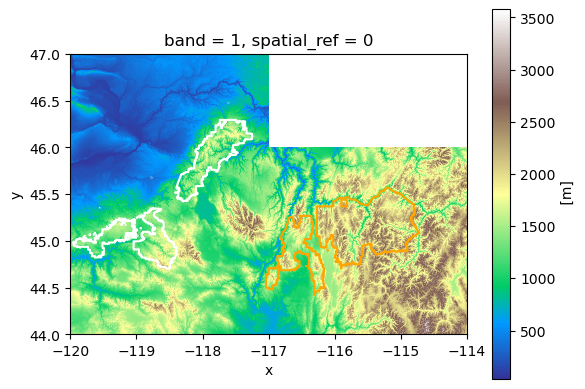

In [ ]:
# Open each unzipped raster tile, put it into a list
# Then merge the tiles using rioxarray.merge
srtm_da_list = []

for file in glob(srtm_pattern):
    tile_da = rxr.open_rasterio(file, mask_and_scale=True).squeeze()
    #bounds = (nfs2_gdf.to_crs(tile_da.rio.crs).total_bounds)
    cropped_tile = tile_da.rio.clip_box(*bounds_buffer)
    srtm_da_list.append(tile_da)
    srtm_das = merge_arrays(srtm_da_list)



In [ ]:
# Plot the merged tiles
srtm_das.plot(cmap='terrain')
uma_gdf.boundary.plot(ax=plt.gca(), color='white')
pay_gdf.boundary.plot(ax=plt.gca(), color='orange')

In [ ]:
# Now re-trying the da merge but separately for each forest
# Merge the tiles using rioxarray.merge
srtm_da_list = []

for file in glob(srtm_pattern):
    tile_da = rxr.open_rasterio(file, mask_and_scale=True).squeeze()
    bounds = (nfs2_gdf.to_crs(tile_da.rio.crs).total_bounds)
    cropped_tile = tile_da.rio.clip_box(*bounds)
    srtm_da_list.append(tile_da)
    srtm_das = merge_arrays(srtm_da_list)

# Plot the merged tiles
srtm_das.plot(cmap='terrain')
uma_gdf.boundary.plot(ax=plt.gca(), color='white')
pay_gdf.boundary.plot(ax=plt.gca(), color='orange')

In [131]:
srtm_das.rio.crs

CRS.from_epsg(4326)

In [132]:
uma_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [ ]:

uma_bounds

array([-119.95978198,   44.70581043, -117.24830141,   46.47554947])

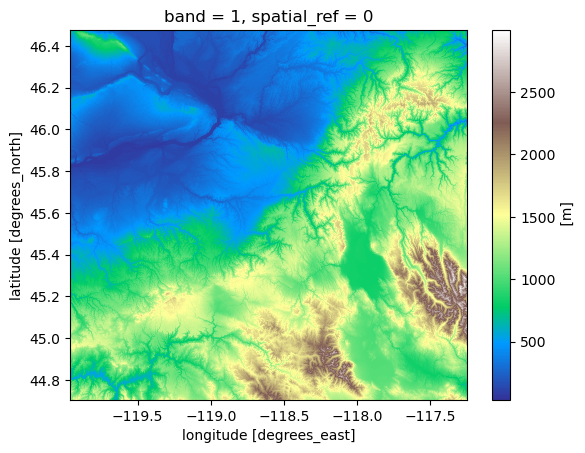

In [ ]:
#split the forests and crop to their extents
uma_bounds = (uma_gdf.to_crs(srtm_das.rio.crs).total_bounds)
srtm_uma_crop = srtm_das.rio.clip_box(*uma_bounds)

srtm_uma_crop.plot(cmap='terrain')

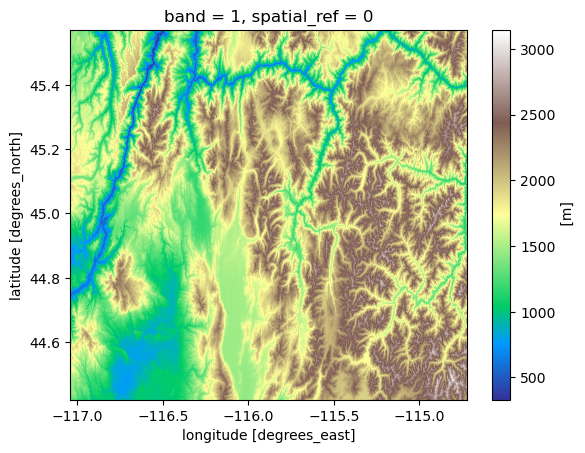

In [140]:
pay_bounds = (pay_gdf.to_crs(srtm_das.rio.crs).total_bounds)
srtm_pay_crop = srtm_das.rio.clip_box(*pay_bounds)

srtm_pay_crop.plot(cmap='terrain')

In [141]:
# Reproject the data to EPGS 32744 (a WGS 84 projection for North America)
srtm_proj_uma = srtm_uma_crop.rio.reproject(32611)
srtm_proj_pay = srtm_pay_crop.rio.reproject(32611)

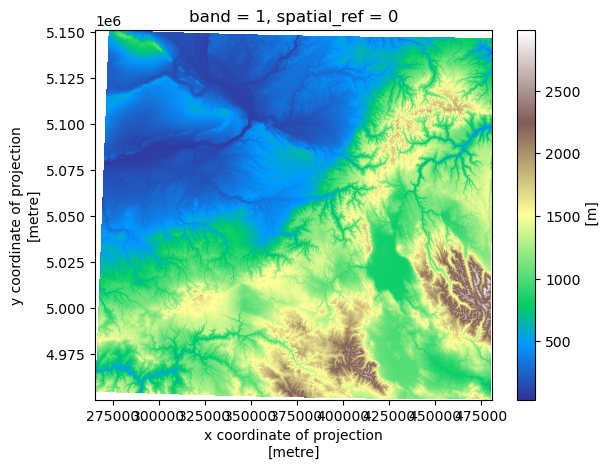

In [142]:
srtm_proj_uma.plot(cmap='terrain')

In [143]:
# calculate slope
slope_da = xrspatial.slope(srtm_proj_uma)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

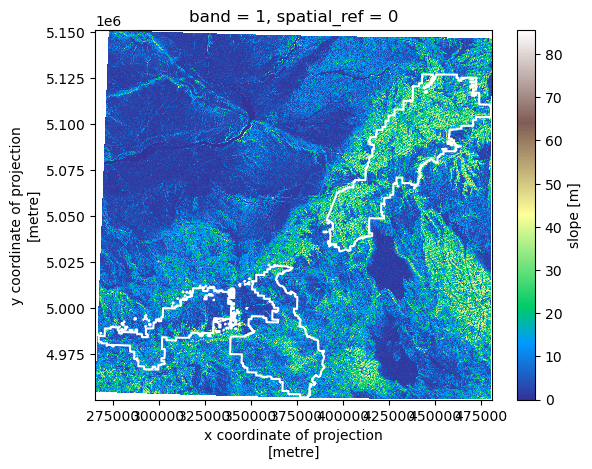

In [145]:
slope_da.plot(cmap='terrain')
uma_gdf.to_crs(32611).boundary.plot(ax=plt.gca(), color='white')


Willamette National Forest

https://www.srs.fs.usda.gov/pubs/misc/ag_654/volume_1/larix/occidentalis.htm
"Western larch grows in a relatively moist-cool climatic zone, with low temperature limiting its upper elevational range and deficient moistures its lower extremes (44). Mean annual temperature within the larch zone is about 7° C (45° F), but annual maximums average 29° C (84° F) and minimums average -9° C (15° F) (table 1) (35). Average temperatures during the May through August growing season are about 16° C (60° F) with July the warmest month. The frost-free season varies from about 60 to 160 days, usually from early June through early September. Frosts can occur any month of the year."

"Soils and Topography
Western larch grows on a wide variety of soils. The most extensive soils have developed in glacial till or colluvium composed of materials derived from limestone, argillite, and quartzite bedrocks of the Precambrian belt geologic series. Larch also grows on soils developed in Recent and Tertiary alluvium and Pleistocene lake sediments. Most soils suitable for the growth of western larch are deep and well drained. Soils developed in glacial till, colluvium, and recent alluvium have nongravelly to gravelly loamy surfaces and gravelly to extremely gravelly loamy subsoils. Volcanic ash is often incorporated into the surface horizon. Soils developed in Tertiary sediments or Pleistocene lake sediments have silt loam surfaces and silt loam, silty clay loam, silty clay, or clay subsoils.

Most soils supporting the growth of western larch are classified in two orders of the soil taxonomy: Inceptisols and Alfisols. Occasionally western larch is found on soils of the order Spodosols, but Spodosols are not extensive within the range of western larch and generally occur above the upper elevational limits of the species. A majority of the soils supporting the growth of western larch are the Cryoboralf, Cryochrept, and Cryandept great groups. Mean annual soil temperature of the soils within the great groups is about 5° C (41° F) at 51 cm (20 in). At low elevations on southern or western exposures within the range of western larch, soil temperatures are warmer and soils supporting the growth of western larch are in the Eutroboralf and Eutrochrept great soil groups.

Western larch grows best on the more moist Eutrochrepts or Eutroboralfs and the lower elevation (warmer) Cryochrepts and Cryoboralfs. It is commonly found growing on valley bottoms, benches, and north- and east-facing mountain slopes. South and west exposures are often too severe for larch seedling establishment, particularly on the drier sites found at larch's lower elevational limits and the southern portion of its range. On moist sites found in the mid-to northern-portion of its range and on mid- to high-elevation sites, larch grows on all exposures."

https://how-to-grow.org/vr/western/t/larch-tree
"So, what are the optimal growing conditions for western larch trees? Let's start with their preferred climate. Western larches thrive in cool, moist climates with mild winters and warm summers. They can tolerate a wide range of temperatures, from -40°F to 100°F, but they prefer temperatures between 60°F and 80°F during the growing season.

In terms of soil, western larches prefer well-drained soils that are slightly acidic (pH between 5.0 and 6.5). They can tolerate a range of soil types, from sandy loam to clay loam, but they do not do well in heavy clay soils or soils that are constantly wet.
Water is also important for the growth and health of western larch trees. They require consistent moisture during the growing season (spring through fall), but they do not like to sit in waterlogged soil. A good rule of thumb is to water deeply once or twice a week during dry spells, making sure the water penetrates at least 12 inches into the soil."


In [ ]:
# POLARIS soil data
soil_dir = os.path.join(data_dir, 'polaris')
os.makedirs(soil_dir, exist_ok=True)

polaris_url_templ = (
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0"
    "/ph/mean/30_60/"
    "late{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
)

polaris_url = polaris_url_templ.format(
    min_lat= , max_lat= , min_lon= , max_lon= )
polaris_url    





In [119]:
nfs2_gdf.total_bounds

array([-119.95978061,   44.4219017 , -114.71994581,   46.47555163])

In [120]:
pay_gdf.total_bounds

array([-117.03989218,   44.4219017 , -114.71994581,   45.56972571])

In [121]:
uma_gdf.total_bounds

array([-119.95978061,   44.70581178, -117.24830028,   46.47555163])

In [ ]:
soil_da = rxr.open_rasterio(soil_url, mask_and_scale=True).squeeze()
soil_da
#polaris_shp_path = os.path.join(soil_dir, ' .shp')

In [ ]:
#Maca v2 metdata
maca_url = (

)

maca_ds = xr.open_dataset(mac_url)
maca_ds